In [12]:
import sys
from pathlib import Path
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings

gpt_path = "/home/cstansbu/.local/lib/python3.9/site-packages/"
sys.path.insert(0, gpt_path)
import scgpt as scg
import faiss

warnings.filterwarnings("ignore", category=ResourceWarning)

In [2]:
# break

In [3]:
model_dir = Path("scgpt_model")

# Load data

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [5]:
ref_data = adata[adata.obs['set'] == 'ref_data', :].copy()
test_data = adata[adata.obs['set'] == 'our_data', :].copy()

print(ref_data)
print()
print(test_data)

AnnData object with n_obs × n_vars = 27346 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

AnnData object with n_obs × n_vars = 8484 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'


# reference embedding

scGPT - INFO - match 14575/14599 genes in vocabulary of size 60697.


/home/cstansbu/.local/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 855/855 [05:17<00:00,  2.69it/s]
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
2024-04-19 12:05:13.170484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 12:05:13.989934: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly differ

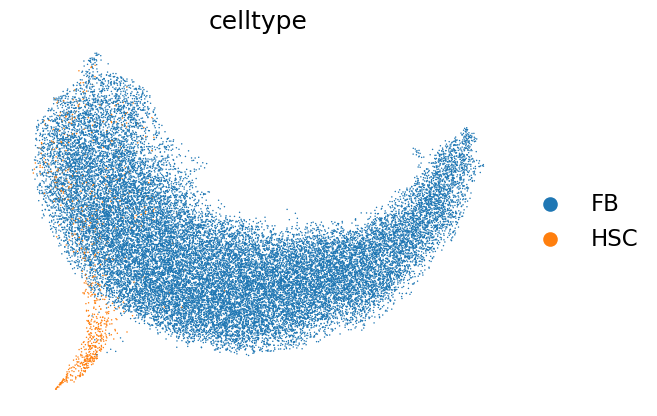

In [6]:
max_length = 2000
batch_size = 32

ref_embed_adata = scg.tasks.embed_data(
    ref_data,
    model_dir,
    gene_col='gene_symbol',
    max_length=max_length,
    batch_size=batch_size,
    obs_to_save=list(adata.obs.columns),
    return_new_adata=True,
)

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, 
           color='celltype',
           frameon=False, wspace=0.4)

# embed our data

scGPT - INFO - match 14575/14599 genes in vocabulary of size 60697.


/home/cstansbu/.local/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 266/266 [01:38<00:00,  2.69it/s]
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserW

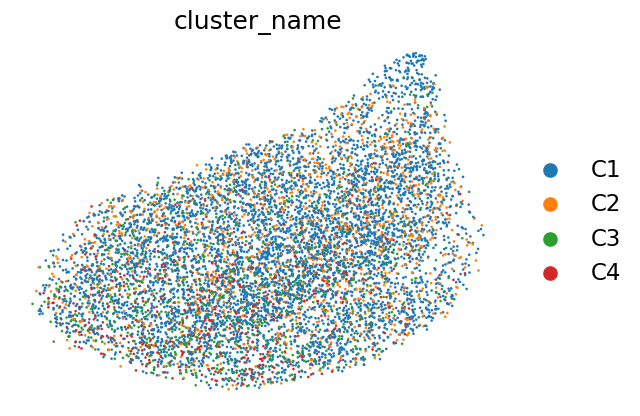

In [7]:
test_embed_adata = scg.tasks.embed_data(
    test_data,
    model_dir,
    gene_col='gene_symbol',
    obs_to_save=list(adata.obs.columns),
    max_length=max_length,
    batch_size=batch_size,
    return_new_adata=True,
)


sc.pp.neighbors(test_embed_adata, use_rep="X")
sc.tl.umap(test_embed_adata)
sc.pl.umap(test_embed_adata, 
           color='cluster_name',
           frameon=False, wspace=0.4)

# Celltype classification based on pretrainned reference embedding

In [8]:
ref_cell_type = 'celltype'

ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 101  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    idx = labels[k]
    nieghbors = ref_embed_adata.obs[ref_cell_type].iloc[idx]
    pred = nieghbors.value_counts(normalize=True)
    preds.append(pred.to_dict())

preds = pd.DataFrame(preds)
preds.head()

,FB,HSC
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


<AxesSubplot: xlabel='variable', ylabel='value'>

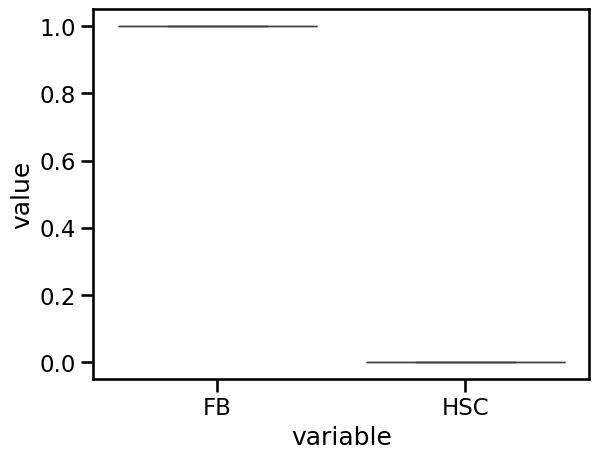

In [16]:
sns.boxplot(data=preds.melt(),
            x='variable',
            y='value')

# Tissue model

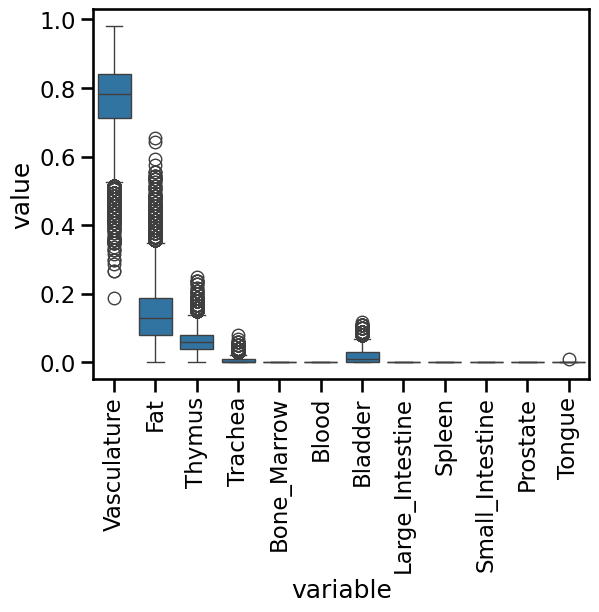

In [20]:
ref_cell_type = 'organ_tissue'

ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 101  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    idx = labels[k]
    nieghbors = ref_embed_adata.obs[ref_cell_type].iloc[idx]
    pred = nieghbors.value_counts(normalize=True)
    preds.append(pred.to_dict())

preds = pd.DataFrame(preds)

sns.boxplot(data=preds.melt(),
            x='variable',
            y='value')
plt.gca().tick_params(axis='x', rotation=90)

# retry with only marker genes

In [23]:
ref_data.var.head()

,gene_id,gene_symbol,is_fb_marker,is_hsc_marker,id_in_vocab
gene_name,,,,,
ATAD3B,ENSG00000160072,ATAD3B,False,False,2745
SKI,ENSG00000157933,SKI,False,False,31254
PEX14,ENSG00000142655,PEX14,False,False,19363
PLCH2,ENSG00000149527,PLCH2,False,False,19720
SPSB1,ENSG00000171621,SPSB1,False,False,32280


In [24]:
ref_data = ref_data[:, (ref_data.var['is_fb_marker'] | ref_data.var['is_hsc_marker'])]
test_data = test_data[:, (test_data.var['is_fb_marker'] | test_data.var['is_hsc_marker'])]


print(ref_data)
print()
print(test_data)

View of AnnData object with n_obs × n_vars = 27346 × 206
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker', 'id_in_vocab'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

View of AnnData object with n_obs × n_vars = 8484 × 206
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker', 'id_in_vocab'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'


/home/cstansbu/.local/lib/python3.9/site-packages/scgpt/tasks/cell_emb.py:212: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [


scGPT - INFO - match 206/206 genes in vocabulary of size 60697.


/home/cstansbu/.local/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 855/855 [00:24<00:00, 35.49it/s]
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserW

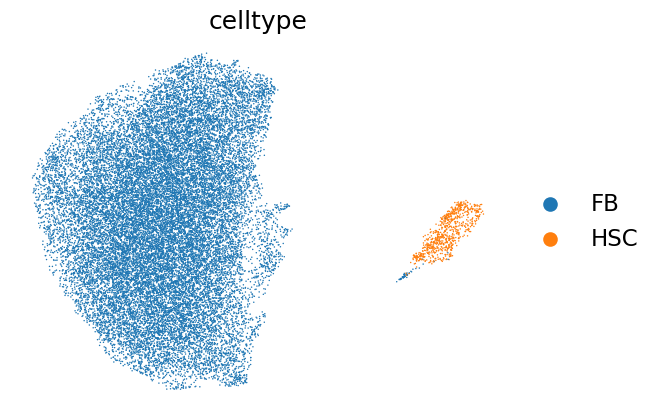

In [25]:
max_length = 2000
batch_size = 32

ref_embed_adata = scg.tasks.embed_data(
    ref_data,
    model_dir,
    gene_col='gene_symbol',
    max_length=max_length,
    batch_size=batch_size,
    obs_to_save=list(adata.obs.columns),
    return_new_adata=True,
)

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, 
           color='celltype',
           frameon=False, wspace=0.4)

scGPT - INFO - match 206/206 genes in vocabulary of size 60697.


/home/cstansbu/.local/lib/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 266/266 [00:07<00:00, 33.29it/s]
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserW

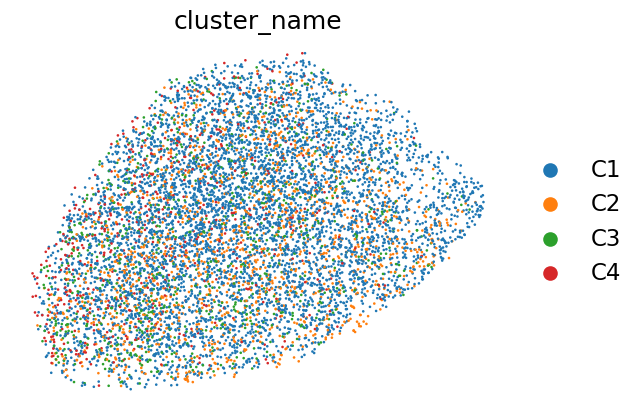

In [27]:
test_embed_adata = scg.tasks.embed_data(
    test_data,
    model_dir,
    gene_col='gene_symbol',
    obs_to_save=list(adata.obs.columns),
    max_length=max_length,
    batch_size=batch_size,
    return_new_adata=True,
)


sc.pp.neighbors(test_embed_adata, use_rep="X")
sc.tl.umap(test_embed_adata)
sc.pl.umap(test_embed_adata, 
           color='cluster_name',
           frameon=False, wspace=0.4)

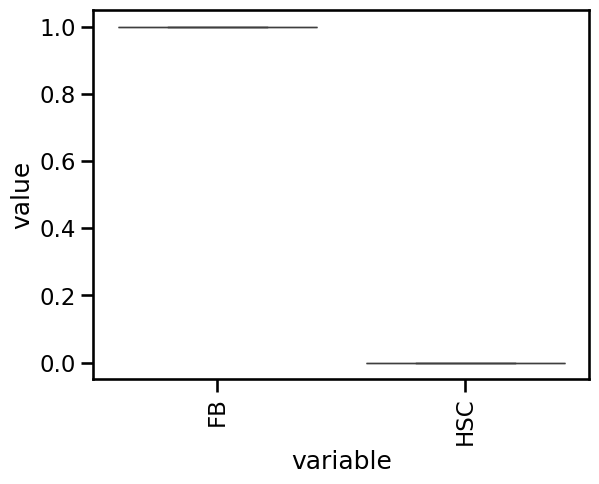

In [29]:
ref_cell_type = 'celltype'

ref_cell_embeddings = ref_embed_adata.X
test_emebd = test_embed_adata.X

k = 101  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    idx = labels[k]
    nieghbors = ref_embed_adata.obs[ref_cell_type].iloc[idx]
    pred = nieghbors.value_counts(normalize=True)
    preds.append(pred.to_dict())

preds = pd.DataFrame(preds)


sns.boxplot(data=preds.melt(),
            x='variable',
            y='value')

# Try a DEG approach